# Gradient Boosting Decision Tree for SN classification

In [13]:
import pywt, os, sys, glob, warnings, time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import template_lc
from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils import m52snr, radec2pix
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs')
from opsimUtils import *

In [2]:
import george
from george import kernels
from functools import partial
from astropy.io import fits
from astropy.table import Table, Column

The metric aims to simulate observed lc from the a simulated LSST SN survey

In [3]:
class DEmetric(BaseMetric):
    """
    This metric aims to simulate observed lc with LSST from oberved templates and to measure the detection efficiency .
    
    Parameters:
    ___________
    Survey Parameters:
        mjdCol= MJD observations column name from Opsim database      (DEFAULT = expMJD) 
        m5Col= Magnitude limit column name from Opsim database      (DEFAULT = fiveSigmaDepth)
        filterCol= Filters column name from Opsim database      (DEFAULT = filter)
        RACol= RA column name from Opsim database      (DEFAULT = fieldRA)
        DecCol= Dec column name from Opsim database      (DEFAULT = fieldDec)
        surveyDuration= Survey Duration      (DEFAULT = 10)
        surveyStart= Survey start date      (DEFAULT = None)
   
    Template parameters:
        templates= dictionary with all the SNe templates     (DEFAULT= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}})
        z = array with z min, z max and z step for the redshift range     (DEFAULT= [0.1,1,0.1])
        explosiontime = times of explosion array      (DEFAULT= None)
        
    
    Detection parameters:
        detectSNR= dictionary with SNR threshold for each filter    (DEFAULT = {'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})
        nFilters= None or number to define the threshold number of filter to be detected  (DEFAULT = None)
        npoints= integer, threshold number of points detected on the lightcurve   (DEFAULT = 3)
        
    __________
    
    OUTPUT:
        dataout = True, Dictionary containing the coordinates of all the SNe detected, the time of explosions and the number of 
        detected and no-detected .
        
        dataout = False, fraction of detected SNe
        
    """
    def __init__(self, metricName='DEmetric', mjdCol='expMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec' 
                 ,surveyDuration=10.,surveyStart=None, opsim=None,
                 observedFilter=['g','r','i'],templates= {'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}},
                 z=[0.1,1,0.1], explosiontime=None, 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                 nFilters=None, npoints=3, dataout=False, **kwargs):
        
        "Survey Parameters"
        self.observedFilter= observedFilter
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.RACol = RACol
        self.DecCol=DecCol
        self.filterCol = filterCol
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart 
        self.opsim = opsim
        "templates"
        self.templates=templates
        "Parameters to generate magnitude for a template lc at different redshits and explosion times"
        self.z = z
        self.explosiontime = explosiontime    
        "Parametes to contrains the detections' selection"
        self.nFilters = nFilters
        self.npoints = npoints
        self.detectSNR = detectSNR
        "Paremeters to select the kind of output"
        self.dataout = dataout
        
        # if you want to get the light curve in output you need to define the metricDtype as object
        if self.dataout:
            super(DEmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol,self.RACol,self.DecCol],
                                                       metricDtype='object', units='',
                                                       metricName=metricName, **kwargs)
        else:
            super(DEmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol],
                                                       units='Fraction Detected', metricName=metricName,
                                                       **kwargs)
        
        
        
        
        self.lcdir = './LC_ML_{}'.format(self.opsim)
        if not os.path.exists(self.lcdir):
            os.makedirs(self.lcdir)
        # The SN template light curves are simulated at the redshifts in the redshift range  
        # K-correction is applied at each redshift z 
        zmin = self.z[0]
        zmax = self.z[1]
        zstep = self.z[2]
        temp = template_lc.template_lc(sn_group= self.templates, z_min=zmin,z_max= zmax,z_step=zstep)
        self.obs_template = temp.run()
        self.zrange = temp.zrange
        self.filtri = temp.filtri
        for j, z in enumerate(self.zrange):
                for ty in self.templates:       
                    for sty in self.templates[ty]:
                        for sn in self.templates[ty][sty][0]:
                            asciifile = 'snlc_{}_z={}_ML.ascii'.format(sn,str(z))
                            ff = open(asciifile,'w')
                            if ty in ['Ia','Ibc']:    endTime = 50.*(1+z)
                            else:                     endTime =100.*(1+z)
                            for f in self.filtri:
                                for i,p in enumerate(self.obs_template['phobs'][sn][z][f]):
                                    if self.obs_template['phobs'][sn][z][f][i] > endTime: break    
                                    ff.write('{:.2f} {:.3f} {}\n'.format(p,self.obs_template['magobs'][sn][z][f][i],f))
                            ff.close()
                            
                            
             
    def read_lightCurve(self, asciifile):
        """Reads in an ascii file, from the simulated ligh curves, 3 columns: epoch, magnitude, filter

        Returns
        -------
        numpy.ndarray
            The data read from the ascii text file, in a numpy structured array with columns
            'ph' (phase / epoch, in days), 'mag' (magnitude), 'flt' (filter for the magnitude).
        """
        if not os.path.isfile(asciifile):
            raise IOError('Could not find lightcurve ascii file %s' % (asciifile))
        self.lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])
        self.transDuration = self.lcv_template['ph'].max() - self.lcv_template['ph'].min()

    def make_lightCurve(self, time, filters):
        """Turn lightcurve definition into magnitudes at a series of times.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
             The magnitudes of the transient at the times and in the filters of the observations.
        """
        lcMags = np.zeros(time.size, dtype=float)
        for key in set(self.lcv_template['flt']):
            fMatch_ascii = np.where(np.array(self.lcv_template['flt']) == key)[0]
            # Interpolate the lightcurve template to the times of the observations, in this filter.
            temp_ph=np.array(self.lcv_template['ph'], float)[fMatch_ascii]-np.array(self.lcv_template['ph'], float)[fMatch_ascii][0]
            lc_ascii_filter = np.interp(time, temp_ph,
                                        np.array(self.lcv_template['mag'], float)[fMatch_ascii])
            lcMags[filters == key.decode("utf-8")] = lc_ascii_filter[filters == key.decode("utf-8")]
        return lcMags
    
    
    def run(self, dataSlice, slicePoint=None): 
        
        # Sort the entire dataSlice in order of time.
        dataSlice.sort(order=self.mjdCol)
        
        # Check that surveyDuration is not larger than the time of observations we obtained.
        # (if it is, then the nTransMax will not be accurate).
        tSpan = (dataSlice[self.mjdCol].max() - dataSlice[self.mjdCol].min()) / 365.25
        surveyDuration = np.max([tSpan, self.surveyDuration])
        
        lc = {}
        filterNames = self.observedFilter
        filterN= ''.join(filterNames)
        fieldRA = np.median(dataSlice['fieldRA']) 
        fieldDec = np.median(dataSlice['fieldDec'])
        
        
        expldist=[]
        # We set the survey duration if it is not given as input
        if self.surveyStart is None:
            surveyStart = dataSlice[self.mjdCol].min()
        else:
            surveyStart = dataSlice[self.mjdCol].min() + 365*self.surveyStart
        
        
        """
        the array of the explosion dates has three possible setting:
            self.explosiontime = integer,  it sets the number of dates to drawn randomly from the Opsim database
            self.explosiontime = None, one date is randomly drawn from the Opsim database
            self.explosiontime = list or array, it sets the array containing the explosion dates
        """
        if isinstance(self.explosiontime, int):
            expl_t =np.random.choice(dataSlice[self.mjdCol],self.explosiontime)
        elif  self.explosiontime is None:
            expl_t=np.random.choice(dataSlice[self.mjdCol],1)
        elif isinstance(self.explosiontime, (list, tuple, np.ndarray)):
            expl_t=np.array(self.explosiontime)+surveyStart
                
        if all(np.in1d(self.observedFilter, dataSlice[self.filterCol])): #check if all the filters for the observed lightcurves are available
            
            index_filter = np.in1d( dataSlice[self.filterCol], self.observedFilter) #filtri presenti nello slice
            obs_filter = dataSlice[self.filterCol][index_filter] #seleziono solo i filtri che ci sono 
            obs = dataSlice[self.mjdCol][index_filter]
            obs_m5 = dataSlice[self.m5Col][index_filter]
            
            classify =pd.DataFrame(index=self.zrange,columns=['pixId', 'Ia','Ibc','II','UNKNOWN','nlc','noClass'])
            classify['pixId']=radec2pix(16,np.radians(fieldRA),np.radians(fieldDec))
            for j, z in enumerate(self.zrange):
                """
                Observed light curve simulation step:
                """
                print('z={}'.format(z))
                sn_list = 0 #inizializzo indice per condate le SNe simulate
                nDetected = 0 #inizializzo indice per condate le SNe detected
                nNoDetected = 0    #inizializzo indice per condate le SNe non detected               
                listout=[]
                for ty in self.templates:
                    lc[ty]={}       
                    for sty in self.templates[ty]:
                        lc[ty][sty]={}
                        for sn in self.templates[ty][sty][0]:
                            lc[ty][sty][sn]={}          
                            asciifile = 'snlc_{}_z={}_ML.ascii'.format(sn,str(z))
                            self.read_lightCurve(asciifile) # we read the simulated lightcurve at the given z
                            zz= [sn,  'z='+str(z)]
                            for k,times in enumerate(expl_t):
                                expldist.append(times) 
               
                                indexlc = np.where((obs>= times) & (obs<=times+self.transDuration)) # we create a mask for all the observation whitin the transient duration
                                lcEpoch = (obs[indexlc] - surveyStart ) % self.transDuration # define the dates of the phases from the explosion time 
                                
                                if np.size(indexlc)>0:  
                                   
                
                                    
                                    lcMags = self.make_lightCurve(lcEpoch, obs_filter[indexlc]) # Generate the observed light curve magnitudes based on the SNR
                                    e = np.absolute(np.diff(lcEpoch))
                                    mask = np.where(e<0.3)
                                    if np.size(mask):
                                        lcopy = np.copy(lcMags)
                                        ecopy = np.copy(lcEpoch)
                                        lcopy[mask[0]] = (lcopy[mask[0]]+lcopy[mask[0]+1])/2
                                        ecopy[mask[0]] = (ecopy[mask[0]]+ecopy[mask[0]+1])/2
                                        #print([ecopy[mask[0]],ecopy[mask[0]+1]])
                                        lcMags = lcopy
                                        lcEpoch = ecopy
                                    lcSNR = m52snr(lcMags, obs_m5[indexlc])
                                    
                         
                                    lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
                                    nfilt = []
                                    for f in self.observedFilter:                    
                                            filtermatch = np.where(obs_filter[indexlc] == f)
                                            lcpoints_AboveThresh[filtermatch] = np.where(lcSNR[filtermatch] >= self.detectSNR[f],True,False) # we define a mask for the detected points on the light curve
                                            
                                            Dpoints = np.sum(lcpoints_AboveThresh[filtermatch]) #counts the number of detected points
                                           
                                            if Dpoints>=self.npoints: nfilt.append(True) # check on the threshold
                                    
                                    lc[ty][sty][sn][times] = {}
                                    lc[ty][sty][sn][times]["Mags"] = lcMags
                                    lc[ty][sty][sn][times]["filter"] = obs_filter[indexlc]
                                    lc[ty][sty][sn][times]["SNR"] = lcSNR
                                    lc[ty][sty][sn][times]["Epoch"] = lcEpoch
                                    lc[ty][sty][sn][times]['detect'] = lcpoints_AboveThresh


                                    # producing a file to pass to PSNID for the classification

                                    mag = {}
                                    jd = {}
                                    merr = {}
                                    snr={}

                                    output  = 'SURVEY:  LSST \n'                
                                    output += 'SNID: {}_{} \n'.format(zz[0],k)
                                    output += 'IAUC:    UNKNOWN \n'             
                                    output +=  'RA:     '+str(fieldRA)+'  deg \n'
                                    output +=  'DECL:   '+str(fieldDec)+'  deg \n'
                                    output +=  'MWEBV:    0.0  MW E(B-V) \n'                           
                                    output +=  'REDSHIFT_FINAL:  '+str(z)+' +- '+'%5.3f' % self.z[2]+' (CMB)\n'
                                    output +=  'FILTERS:  {}   \n'.format(filterN)               
                                    output +=  ' \n'
                                    output += '# ======================================\n' 
                                    output += '# TERSE LIGHT CURVE OUTPUT\n' 
                                    output += '#\n' 
                                    output += 'NOBS: {} \n'.format(np.size(lcMags[lcpoints_AboveThresh])) 
                                    output += 'NVAR: 8 \n'
                                    output += 'VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR \n'
                                    for f in filterNames:
                                        filtermatch = np.where(obs_filter[indexlc] == f)
                                        detect= np.array(lc[ty][sty][sn][times]['detect'][filtermatch])
                                        mag[f] = lcMags[filtermatch][detect]
                                        jd[f] = obs[indexlc][filtermatch][detect]
                                        snr[f] = lcSNR[filtermatch][detect]
                                        merr[f] = 2.5*np.log10(1+1/snr[f])
                                        for h,j in enumerate(jd[f]):
         
                                            fl = 10**(-0.4*(mag[f][h]))*1e11
                                            if snr[f][h]>1: 
        
                                                flerr = fl/snr[f][h]/1.3
                                            else: 
        
                                                flerr = fl/1.1
                                            output += 'OBS: %9.3f   %s NULL  %7.3f  %7.3f  %7.3f  %7.3f  %7.3f \n' % (j,f,fl,flerr,snr[f][h],mag[f][h],merr[f][h])
                                    output +='END: '
                                    if self.nFilters: 
                                        if np.sum(nfilt) >= self.nFilters:
                                            ofile = open(os.path.join(self.lcdir,'LSST_{}_{}_ra{}_dec{}_{}.dat'.format(sn,zz[1],np.round(fieldRA,2),np.round(fieldDec,2),k)),'w')
                                            ofile.write(output)
                                            ofile.close()                                            
                                            nDetected += 1
                                        else:
                                            nNoDetected += 1
                                    else:
                                        if any(nfilt): 
                                            ofile = open(os.path.join(self.lcdir,'LSST_{}_{}_ra{}_dec{}_{}.dat'.format(sn,zz[1],np.round(fieldRA,2),np.round(fieldDec,2),k)),'w')
                                            ofile.write(output)
                                            ofile.close() 
                                            nDetected += 1
                                        else:
                                            nNoDetected += 1
                                
                                else:
                                    expl_t = np.delete(expl_t, np.where(expl_t==times))
                                    nNoDetected += 1
                
                  
                
                
            print('DE= {}'.format(np.round(nDetected/(nDetected+nNoDetected),2)))                                                                                           
            if self.dataout:
                explosiontime= np.array(expldist)
                return {'detected':[nDetected,nNoDetected], 'field':[fieldRA,fieldDec],'time_expl':explosiontime}

            else:
                N=  nDetected/(nDetected+nNoDetected)
                return float(N)

In [4]:
def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : astropy.table.Table
        Table with evaluated Gaussian process curve and errors at each
        passband.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred,
                                           np.sqrt(pb_pred_var)))
        obj_gp_pb = Table([obj_gp_pb_array[:, 0], obj_gp_pb_array[:, 1],
                           obj_gp_pb_array[:, 2], np.vectorize(wavelengths_pb.get)(np.repeat(wavelength,number_gp))],
                          names=['mjd', 'flux', 'flux_error', 'filter'],dtype=['<f8','<f8','<f8','<U1'])

        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = np.vstack((obj_gps, obj_gp_pb))
    
    # Map the wavelenghts to the original passband denominations
    #obj_gps['filter'] = np.vectorize(wavelengths_pb.get)(obj_gps['filter'])

    return obj_gps


In [5]:
colours = {'sdssu': '#6614de', 'sdssg': '#007718', 'sdssr': '#b30100',
           'sdssi': '#d35c00', 'sdssz': 'k', 'desg': '#007718',
           'desr': '#b30100', 'desi': '#d35c00', 'desz': 'k',
           'u': '#984ea3', 'g': '#377eb8', 'r': '#4daf4a',
           'i': '#e3c530', 'z': '#ff7f00', 'y': '#e41a1c'}

sntypes = {1: 'Ia', 2: 'II', 21: 'IIn', 22: 'IIP', 23: 'IIL',
           3: 'Ibc', 32: 'Ib', 33: 'Ic', 66: 'other'}
markers = {'desg': '^', 'desr': 'o', 'desi': 's', 'desz': '*',
           'u': 'o', 'g': 'v', 'r': '^',
           'i': '<', 'z': '>', 'y': 's'}
labels = {'desg': 'g', 'desr': 'r', 'desi': 'i', 'desz': 'z'}
def plot_obj_and_model(obj_data, obj_model=None, **kwargs):
        """Plot an object observations and the model fitted to them.

        If `obj_model` is not provided, the function only plots the light
        curve observations.

        Parameters
        ----------
        obj_data : pandas.core.frame.DataFrame or astropy.table.Table
            Time, flux, flux error and passbands of the object.
        obj_model : {None, astropy.table.Table, pandas.core.frame.DataFrame},
                    optional
            If `None`, only plots `obj_data`. Otherwise, `obj_model` has the
            time, flux, flux error (optional) and passbands of the model
            fitted to the object.
        **kwargs : dict
            Additional keyword arguments that can replace default parameters in
            other funtions:
            - axes : {None, matplotlib.axes}, optional
                If the axes are provided, the figure is plotted on the axes.
                Otherwise, it is plotted directly with `matplotlib`.
            - pb_colors : dict, optional
                Mapping between the passband names and the colours with which
                they are represented. If none mapping is provided, the
                passbands are represented with the default colours.
            - show_title : Bool, default = False
                Whether to show the plot title.
            - title : str, optional
                The title for the plot.
            - show_legend : Bool, default = True
                Whether to show the plot legend.

        Raises
        ------
        AttributeError
            There is a default title if `obj_data` contains the object id and
            redshift accessible through `obj_data.meta['name']` and
            `obj_data.meta['hostgal_photoz']`, respectively.
            Otherwise, if the kwarg `show_title` is `True` a title must be
            provided in the kwarg `title`.
        """
        # Extra plotting parameters passed as kwargs
        if 'axes' in kwargs:
            axes = kwargs['axes']
        else:
            axes = None
        if 'pb_colors' in kwargs:
            pb_colors = kwargs['pb_colors']
        else:
            pb_colors = colours
        if 'show_title' in kwargs:
            show_title = kwargs['show_title']
        else:
            show_title = False
        if 'title' in kwargs:
            title = kwargs['title']
        elif show_title is True:
            try:
                title = 'Object ID: {}\nPhoto-z = {:.3f}'.format(
                    obj_data.meta['name'], obj_data.meta['hostgal_photoz'])
            except AttributeError:
                raise AttributeError('No default title available. Provide the'
                                     ' desired title in the kwarg `title`.')
        if 'show_legend' in kwargs:
            show_legend = kwargs['show_legend']
        else:
            show_legend = True

        #passbands = ['u', 'g', 'r', 'i', 'z', 'y']
        passbands = ['g', 'r', 'i']
        for pb in passbands:
            # Get the light curve observations in the chosen passband `pb`
            obj_data_pb = obj_data[obj_data['filter'] == pb]

            # Skip this code block and plot only the light curve observations
            # if no `obj_model` was inputed.
            if obj_model is not None:
                # Get the model observations in the chosen passband `pb`
                obj_model_pb = obj_model[obj_model['filter'] == pb]
                model_flux = obj_model_pb['flux']

                # Plot the model values
                if axes is None:
                    plt.plot(obj_model_pb['mjd'], model_flux,
                             color=pb_colors[pb], alpha=.7, label='')
                else:
                    axes.plot(obj_model_pb['mjd'], model_flux,
                              color=pb_colors[pb], alpha=.7, label='')
                try:  # if the model has error information, plot it
                    model_flux_error = obj_model_pb['flux_error']
                    if axes is None:
                        plt.fill_between(x=obj_model_pb['mjd'],
                                         y1=model_flux-model_flux_error,
                                         y2=model_flux+model_flux_error,
                                         color=pb_colors[pb], alpha=.15,
                                         label=None)
                    else:
                        axes.fill_between(x=obj_model_pb['mjd'],
                                          y1=model_flux-model_flux_error,
                                          y2=model_flux+model_flux_error,
                                          color=pb_colors[pb], alpha=.15,
                                          label=None)
                except KeyError:  # the model has no error information
                    pass

            # Plot the object observations.
            # They are ploted after the models to be on top of these.

            # Get the right marker for the plot
            try:
                marker_pb = markers[pb]
            except KeyError:  # no marker for this passband
                marker_pb = 'o'
            if axes is None:
                plt.errorbar(obj_data_pb['mjd'], obj_data_pb['flux'],
                             obj_data_pb['flux_error'], fmt=marker_pb,
                             color=pb_colors[pb], label=pb[-1])
            else:
                axes.errorbar(obj_data_pb['mjd'], obj_data_pb['flux'],
                              obj_data_pb['flux_error'], fmt=marker_pb,
                              color=pb_colors[pb], label=pb[-1])
        if axes is None:
            plt.xlabel('Time (days)')
            plt.ylabel('Flux units')
        else:
            axes.set_xlabel('Time (days)')
            axes.set_ylabel('Flux units')

        if show_title:
            if axes is None:
                plt.title(title)
            else:
                axes.set_title(title)

        if show_legend:
            if axes is None:
                plt.legend(ncol=2, handletextpad=.3, borderaxespad=.3,
                           labelspacing=.2, borderpad=.3, columnspacing=.4)
            else:
                axes.legend(ncol=2, handletextpad=.3, borderaxespad=.3,
                            labelspacing=.2, borderpad=.3, columnspacing=.4)

In [6]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7_ML'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))
    
dbRuns = show_opsims(dbDir)
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [7]:
surveyDuration = 1
init = 1
sqlconstraint_WFD = '(filter= "u" or filter= "g" or  filter = "r" or filter="i"  or filter="z")'
sqlconstraint_WFD+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )
sqlconstraint_WFD+='and proposalId=1'

In [8]:
nside = 16
slicer = slicers.HealpixSlicer(nside=nside)
#slicer=slicers.UniSlicer()
pixelarea = hp.nside2pixarea(nside,degrees=True)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


The templates group that is considered in the simulation

In [9]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [10]:
expl_range=np.arange(0,365,10)
expl_range.size

37

The observed lc database from the simulated SN survey

In [11]:
dbmetric = ['baseline_nexp1_v1.7_10yrs','ddf_dither0.30_v1.7_10yrs','euclid_dither4_v1.7_10yrs', 
            'footprint_8_v1.710yrs','cadence_drive_gl30_gcbv1.7_10yrs',
            'rolling_scale1.0_nslice3_v1.7_10yrs','twi_pairs_mixed_repeat_v1.7_10yrs',
            'u_long_ms_30_v1.7_10yrs']

In [ ]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7_ML'.format(your_username)
for run in dbRuns:
    warnings.filterwarnings('ignore')
    print('##############\n')
    print('{} is running\n'.format(run))
    print('##############\n')
    start_time = time.time()
    metriclc = DEmetric(z=[0.1,1,0.1], metricName='DEmetric', mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration, opsim=run,\
                              templates= sngroups,explosiontime=expl_range,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, nFilters=1, \
                              npoints=3,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint_WFD)
    bundleDict={'DEmetric':metriclc_trans}
    metriclc_trans.setRunName(run)
    #metriclc_get_Colmetric.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    bgrouplc.runAll()
    print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
    print('####################\n')

##############

rolling_nm_scale0.6_nslice2_v1.7_10yrs is running

##############

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.2
1990N r B 0.2
1990N i V 0.2
1990N g B 0.3
1990N r B 0.3
1990N i V 0.3
1990N g B 0.4
1990N r B 0.4
1990N i V 0.4
1990N g B 0.5
1990N r B 0.5
1990N i B 0.5
1990N g B 0.6
1990N r B 0.6
1990N i B 0.6
1990N g B 0.7
1990N r B 0.7
1990N i B 0.7
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
1990N g B 0.9
1990N r B 0.9
1990N i B 0.9
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1992A g B 0.2
1992A r B 0.2
1992A i V 0.2
1992A g B 0.3
1992A r B 0.3
1992A i V 0.3
1992A g B 0.4
1992A r B 0.4
1992A i V 0.4
1992A g B 0.5
1992A r B 0.5
1992A i B 0.5
1992A g B 0.6
1992A r B 0.6
1992A i B 0.6
1992A g B 0.7
1992A r B 0.7
1992A i B 0.7
1992A g B 0.8
1992A r B 0.8
1992A i B 0.8
1992A g B 0.9
1992A r B 0.9
1992A i B 0.9
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
1994D g B 0.2
1994D r B 0.2
1994D i V 0.2
1994D g B 0.3
1994D r B 0.3
1994D i V 0.3
1994D g B

In [14]:
listobs = glob.glob('./LC_ML/*dat')
print(len(listobs))
listobs[40:50]

3775


['./LC_ML/LSST_2009bw_z=0.1_1.dat',
 './LC_ML/LSST_2009bw_z=0.1_2.dat',
 './LC_ML/LSST_1999br_z=0.1_0.dat',
 './LC_ML/LSST_1999br_z=0.1_1.dat',
 './LC_ML/LSST_1999br_z=0.1_2.dat',
 './LC_ML/LSST_1999gi_z=0.1_0.dat',
 './LC_ML/LSST_1999gi_z=0.1_1.dat',
 './LC_ML/LSST_1999gi_z=0.1_2.dat',
 './LC_ML/LSST_2005cs_z=0.1_1.dat',
 './LC_ML/LSST_2005cs_z=0.1_2.dat']

In [15]:
obs={l:{}for l in listobs}
for lobs in obs.keys():
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,flux_obs,fluxerr_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        flux_obs.append(float(l[i].split()[4]))
        fluxerr_obs.append(float(l[i].split()[5]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'flux':np.array(flux_obs),
                      'flux_err':np.array(fluxerr_obs),'filter':np.array(f_obs)}})
    

Different grouping for LC analysis

In [118]:
# n points > 15
obs_max20 = {}
for nn in n:
    obs_n[nn]={}
    for l in listobs:
        for z in obs[l].keys():
            if len(obs[l][z]['epoch'])> 20 :
                obs_max20[l] = obs[l]

In [119]:
len(obs_max20)

705

In [24]:
sn_group={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}}

In [16]:
Ia =['1990N','1992A','1994D','2002bo','1991T','1999ee','1991bg','2000cx','2002cx']
Ibc =['2009jf','2008D','1994I','2004aw','2007gr','1998bw']
II =['1999em','2004et','2009bw','1999br','1999gi','2005cs','1992H','1993J','2008ax','1987A','2010jl','1998S','1997cy','2005gj','2008es']

In [17]:
sn_group={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [31]:
temp = template_lc.template_lc(sn_group=sn_group ,
                               z_min=0.1,z_max= 1.0,z_step=0.1)
obs_template = temp.run()

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1990N g B 0.2
1990N r B 0.2
1990N i V 0.2
1990N g B 0.3
1990N r B 0.3
1990N i V 0.3
1990N g B 0.4
1990N r B 0.4
1990N i V 0.4
1990N g B 0.5
1990N r B 0.5
1990N i B 0.5
1990N g B 0.6
1990N r B 0.6
1990N i B 0.6
1990N g B 0.7
1990N r B 0.7
1990N i B 0.7
1990N g B 0.8
1990N r B 0.8
1990N i B 0.8
1990N g B 0.9
1990N r B 0.9
1990N i B 0.9
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1992A g B 0.2
1992A r B 0.2
1992A i V 0.2
1992A g B 0.3
1992A r B 0.3
1992A i V 0.3
1992A g B 0.4
1992A r B 0.4
1992A i V 0.4
1992A g B 0.5
1992A r B 0.5
1992A i B 0.5
1992A g B 0.6
1992A r B 0.6
1992A i B 0.6
1992A g B 0.7
1992A r B 0.7
1992A i B 0.7
1992A g B 0.8
1992A r B 0.8
1992A i B 0.8
1992A g B 0.9
1992A r B 0.9
1992A i B 0.9
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
1994D g B 0.2
1994D r B 0.2
1994D i V 0.2
1994D g B 0.3
1994D r B 0.3
1994D i V 0.3
1994D g B 0.4
1994D r B 0.4
1994D i V 0.4
1994D g B 0.5
1994D r B 0.5
1994D i B 0.5
1994D g 

In [20]:
np.shape(obs_template['magobs'][t][0.1][f])

(204,)

### GP Regression

test su tutte le LC 

In [18]:
gp_param_test={}
t_test= {}
failed=[]
e_pred = np.linspace(-20,100,120)
pb_wavelengths = {"u": 3685., "g": 4802., "r": 6231.,
                  "i": 7542., "z": 8690., "y": 9736.}
wavelengths_pb = {3685.:'u', 4802.:'g', 6231.:'r',
                  7542.:'i', 8690.:'z', 9736.:'y'}
#gp_wavelengths = np.vectorize(pb_wavelengths.get)(filter_set)
for t in obs.keys():
    t_test[t]={}
    for z in obs[t].keys():
        obj_times = obs[t][z]['epoch']-obs[t][z]['epoch'][0]
        obj_flux = obs[t][z]['flux']
        obj_flux_error = obs[t][z]['flux_err']
        obj_wavelengths = np.vectorize(pb_wavelengths.get)(obs[t][z]['filter'])
        
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_flux) / np.sqrt(
        obj_flux_error ** 2 + (1e-2 * np.max(obj_flux)) ** 2)
        scale = np.abs(obj_flux[np.argmax(signal_to_noises)])

        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
        guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")
        gp = george.GP(kernel)
        default_gp_param = gp.get_parameter_vector()
        
        d2d = np.matrix([obj_times,obj_wavelengths])
        gp.compute(d2d.T,obj_flux_error)
        def neg_ln_like(p):
            gp.set_parameter_vector(p)
            loglike= gp.log_likelihood(obj_flux)
            return -loglike if np.isfinite(loglike) else 1e25

        def grad_neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(obj_flux)
        try:
            results = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
            print(results)
            if results.success:
                gp.set_parameter_vector(results.x)
            else:
                # Fit failed. Print out a warning, and use the initial guesses for fit
                # parameters.
                obj = t
                print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
                failed.append(t)
                gp.set_parameter_vector(default_gp_param)

            gp_predict = partial(gp.predict, obj_flux)

            return_results = []
            return_results.append(kernel)
            return_results.append(results.x)
            return_results.append(gp_predict)
            t_test[t][z] = return_results
        except:
            failed.append(t)

      fun: 48.64030358956167
 hess_inv: array([[0.67123471, 0.67669488],
       [0.67669488, 1.13431182]])
      jac: array([ 3.04642095e-06, -2.94454182e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([10.12480697, 10.59548085])
      fun: 110.9306500613595
 hess_inv: array([[0.34433818, 0.22717665],
       [0.22717665, 0.31185464]])
      jac: array([ 9.53701100e-08, -1.34428319e-07])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 8
     njev: 13
   status: 0
  success: True
        x: array([20.18734547,  9.25553387])
      fun: 106.66108307735715
 hess_inv: array([[0.51204919, 0.45808256],
       [0.45808256, 0.6307996 ]])
      jac: array([-2.24066572e-06, -8.97589985e-08])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([19.64003778,  9.5715952 ])
      fun: 122.41509

In [294]:
Table(obj_data)

mjd [100],flux [100],flux_error [100],filter [100]
float64,float64,float64,float64
-20.0 .. 120.0,147.98827044675068 .. -39.478823545187424,20.129967538859646 .. 104.56029852417215,4802.0 .. 4802.0
-20.0 .. 120.0,214.56610069692215 .. 53.31948225923634,11.415715038477826 .. 107.33623748167412,6231.0 .. 6231.0
-20.0 .. 120.0,208.0674767764882 .. 115.52981015717387,15.777076443784244 .. 115.83570280314254,7542.0 .. 7542.0


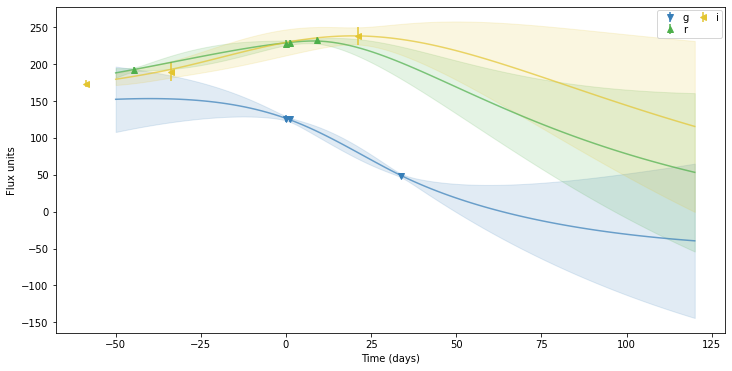

In [326]:
fig,ax= plt.subplots(1,1)
plot_obj_and_model(Table(obs['./LC_ML/LSST_2005cs_z=0.1_0.dat'][0.1]),Table(obj_data),kwargs={'axes':ax})

In [19]:
obj_data={}
for lc in t_test.keys():
    obj_data[lc]={}
    for z in t_test[lc].keys():
        obj_data[lc][z]= predict_2d_gp(t_test[lc][z][2],
                      np.linspace(-50,120,100),
                     np.vectorize(pb_wavelengths.get)(np.array(['r','g','i'])))

### Wavelet decomposition

In [20]:
sym_family = pywt.wavelist('sym')

In [21]:
coeffs = {}
for lc in t_test.keys():
    if lc not in failed:
        coeffs[lc]={}
        for z in t_test[lc].keys():
            for pb in ['g','r','i']:
                obj_pb = obj_data[lc][z][obj_data[lc][z]['filter'] == pb]
                coeffs[lc][pb] = pywt.swt(obj_pb['flux'], wavelet='sym2',
                                      level=2)

### PCA of Wavelet

In [22]:
lcdet=list(t_test.keys())

In [23]:
for t in failed:
    lcdet.remove(t)

In [24]:
filter_set = ['g','r','i']
feature_space = []

for i,lc in enumerate(lcdet):
    if i == 0:  # all events/passbands have the same number of levels
        number_levels = np.shape(coeffs[lc][filter_set[0]])[0]
    coeffs_list = []
    for pb in filter_set:
        pb_coeffs = coeffs[lc][pb]
        for level in np.arange(number_levels):
            level_coeffs = pb_coeffs[level]
            coeffs_list.append(level_coeffs[0])  # cA
            coeffs_list.append(level_coeffs[1])  # cD
    coeffs_list = np.array(coeffs_list).flatten()
    feature_space.append(coeffs_list)
feature_space = np.array(feature_space)  # change list -> array
feature_space = pd.DataFrame(feature_space, index=lcdet)
feature_space.index.rename('object_id', inplace=True)

In [26]:
matrix = feature_space -feature_space.mean(axis=0)
matrix

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
object_id,,,,,,,,,,,,,,,,,,,,,
./LC_ML/LSST_2005cs_z=0.1_0.dat,-501.958763,-627.030098,-731.820765,-799.921248,-814.023902,-825.613272,-834.605370,-841.787734,-847.649399,-852.636764,...,0.163229,0.149531,0.136895,0.125224,0.114439,0.104480,0.095292,0.086819,149.591981,-103.667046
./LC_ML/LSST_2010jl_z=0.1_0.dat,59407.123700,76231.676990,90097.154131,98877.109960,100382.173634,101828.031108,103208.245540,104515.597999,105743.347784,106885.069759,...,-3.149071,-3.295005,-3.426307,-3.544053,-3.649221,-3.742706,-3.825333,-3.897870,-19543.716211,13251.552860
./LC_ML/LSST_2005gj_z=0.1_0.dat,24071.598824,40587.095083,53612.545519,61099.478160,61000.932900,60808.013351,60522.043067,60144.549288,59678.412099,59127.560663,...,-3.073436,-3.034697,-2.992587,-2.947587,-2.900120,-2.850556,-2.799233,-2.746457,-5658.663082,3668.922384
./LC_ML/LSST_2009jf_z=0.1_0.dat,-586.638409,-809.817275,-992.308973,-1105.551333,-1120.038514,-1131.909817,-1140.046186,-1150.046286,-1162.620205,-1159.990852,...,0.176964,0.163819,0.151688,0.140476,0.130107,0.120524,0.111672,0.103498,181.588058,-125.372464
./LC_ML/LSST_1998bw_z=0.1_0.dat,-586.638409,-809.817275,-992.308973,-1105.551333,-1120.038514,-1131.909814,-1131.852595,-1163.084523,-1231.613620,-1174.406455,...,0.176964,0.163819,0.151688,0.140476,0.130107,0.120524,0.111672,0.103498,181.588058,-125.372464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./LC_ML/LSST_1997cy_z=0.6_25.dat,-523.286271,-753.962515,-941.895396,-1057.780558,-1071.439411,-1082.503166,-1090.885914,-1097.373473,-1102.453410,-1106.570971,...,0.170168,0.156542,0.143970,0.132355,0.121618,0.111701,0.102547,0.094103,194.378308,-135.570636
./LC_ML/LSST_2008es_z=0.6_25.dat,-586.638409,-809.817275,-992.308973,-1105.551333,-1120.038514,-1131.909817,-1141.074664,-1148.313638,-1154.108452,-1158.897803,...,0.176964,0.163819,0.151688,0.140476,0.130107,0.120524,0.111672,0.103498,181.588058,-125.372464
./LC_ML/LSST_2005gj_z=0.7_25.dat,-556.745073,-752.756047,-914.125262,-1015.604446,-1030.970200,-1043.796736,-1053.995370,-1062.348523,-1069.339659,-1075.409140,...,0.169823,0.156855,0.144899,0.133858,0.123657,0.114238,0.105547,0.097531,149.004429,-101.816400


In [27]:
u, singular_vals, eigenvecs = np.linalg.svd(matrix,full_matrices=False)

In [28]:
number_objs = np.shape(feature_space)[0]
eigenvals = singular_vals**2 / (number_objs-1)  

In [29]:
tol = .95  # Explain at least 95% of the variance
eigenvals_cumsum = np.cumsum(eigenvals/sum(eigenvals))
index_greater_tol = np.where(eigenvals_cumsum >= tol)
first_index = index_greater_tol[0][0]
# +1 because it is inclusive that index
number_comps = first_index + 1
eigenvecs = eigenvecs[:number_comps, :]

In [30]:
reduced_space = matrix @ eigenvecs.T

In [31]:
reduced_space

,0,1,2,3
object_id,,,,
./LC_ML/LSST_2005cs_z=0.1_0.dat,-1.392354e+04,-1309.250895,1602.627829,1768.747238
./LC_ML/LSST_2010jl_z=0.1_0.dat,2.001314e+06,203541.188697,-137066.923216,76205.987753
./LC_ML/LSST_2005gj_z=0.1_0.dat,6.574947e+05,252799.260325,-63453.446013,-46561.171403
./LC_ML/LSST_2009jf_z=0.1_0.dat,-1.909397e+04,-1285.170025,2523.695961,1276.864110
./LC_ML/LSST_1998bw_z=0.1_0.dat,-1.652329e+04,223.691335,2842.037019,1095.471894
...,...,...,...,...
./LC_ML/LSST_1997cy_z=0.6_25.dat,-1.825150e+04,-2751.996618,2533.310522,1658.952867
./LC_ML/LSST_2008es_z=0.6_25.dat,-2.014736e+04,-1845.301096,2655.789630,1302.486947
./LC_ML/LSST_2005gj_z=0.7_25.dat,-1.891128e+04,-1243.252826,2756.774827,1373.441357


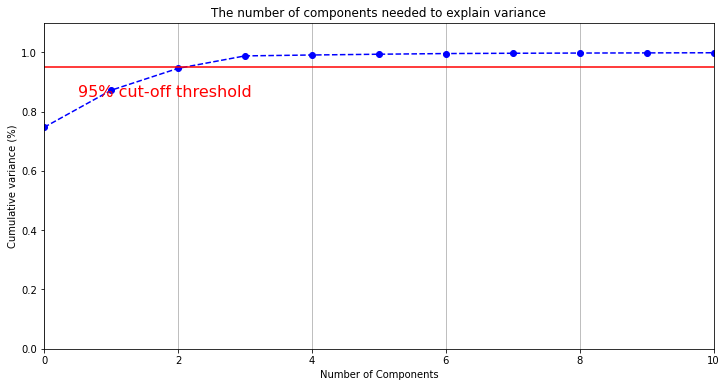

In [375]:
from sklearn.decomposition import PCA
pca = PCA().fit(matrix)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 241, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot( y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
#plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.xlim([0,10])
ax.grid(axis='x')
plt.show()

In [55]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(matrix)
principalComponents_test = pca.fit_transform(matrix_test)

In [ ]:
pca.log

In [355]:
principalComponents.shape

(240, 3)

In [56]:
coeff_matrix = pd.DataFrame(principalComponents)
coeff_matrix_test = pd.DataFrame(principalComponents_test)

In [32]:
types_test = []
for t in lcdet:
    loc= t.split('_')
    if loc[2] in Ia:
        types_test.append(0)
    if loc[2] in Ibc:
        types_test.append(1)
    if loc[2] in II:
        types_test.append(2)
types_test=np.array(types_test)

In [33]:
import lightgbm as lgb

In [34]:
X=reduced_space
Y=np.array(types_test)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)



In [36]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
# predict the results
y_pred=clf.predict(X_test)
y_pred

array([2, 2, 0, ..., 0, 2, 0])

In [38]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7584


In [382]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

ValueError: Found input variables with inconsistent numbers of samples: [2443, 2613]

In [384]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

ValueError: Found input variables with inconsistent numbers of samples: [2443, 2613]

In [39]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9554
Test set score: 0.7584


In [40]:
from sklearn.metrics import confusion_matrix, log_loss
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[265  18  76]
 [ 39  91  32]
 [ 71  17 438]]

True Positives(TP) =  265

True Negatives(TN) =  91

False Positives(FP) =  18

False Negatives(FN) =  39


In [41]:
d=cm/np.sum(cm)
clf_probs = clf.predict_proba(X_test)
logloss= log_loss(y_test, clf_probs)
logloss

0.6093772515574503

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       359
           1       0.72      0.56      0.63       162
           2       0.80      0.83      0.82       526

   micro avg       0.76      0.76      0.76      1047
   macro avg       0.74      0.71      0.72      1047
weighted avg       0.76      0.76      0.76      1047



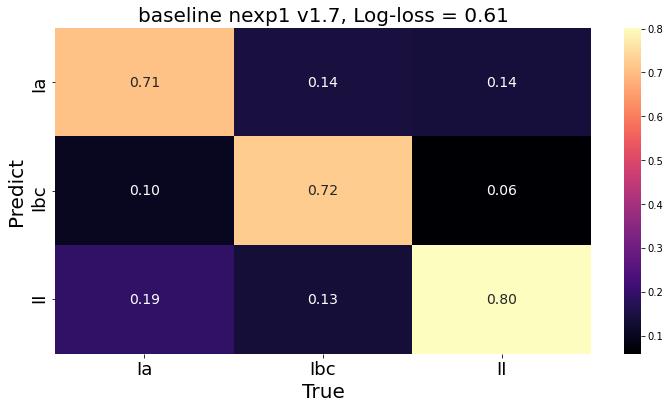

In [396]:
# visualize confusion matrix with seaborn heatmap
import seaborn as sns
cm_matrix = pd.DataFrame(data=d, columns=['Ia', 'Ibc','II'], 
                                 index=['Ia', 'Ibc','II'])
ax = plt.axes()
sns.heatmap(cm_matrix, annot=True, annot_kws={"size":14}, fmt='.2f', cmap='magma',ax=ax)
ax.set_title('baseline nexp1 v1.7, Log-loss = {}'.format(np.round(logloss,2)),fontsize=20)
ax.tick_params('both', labelsize=18)
ax.set_ylabel('Predict', fontsize=20)
ax.set_xlabel('True',fontsize=20)
plt.show()

In [43]:
z_det= []
for lc in lcdet:
    loc= lc.split('_')
    z = loc[3].split('=')[1]
    z_det.append(float(z))
z_det=np.array(z_det)

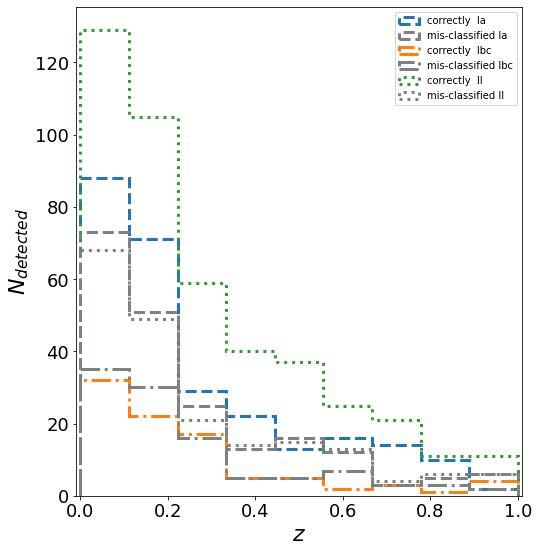

In [44]:
fig, ax=plt.subplots(1,figsize=(8,9))
#for db,c in #zip(dbmetric,cm[0:len(dbmetric)]):
#ax.hist(z_det,np.linspace(0.1,1,9), histtype='step',density=True,linewidth=3,align='left')
valIa, bins, p=ax.hist(z_det[np.where((y_pred==0) &(y_test==0))],np.linspace(0,1,10), histtype='step',linewidth=3,linestyle='dashed',label='correctly  Ia',align='mid')
valmisIa, bins, p=ax.hist(z_det[np.where((y_test==0)!=(y_pred==0) )],np.linspace(0,1,10), histtype='step',linewidth=3,color='grey',linestyle='dashed',label='mis-classified Ia',align='mid')
fIa= valIa/(valIa+valmisIa)
valIbc, bins, p=ax.hist(z_det[np.where((y_pred==1) &(y_test==1))],np.linspace(0,1,10), histtype='step',linewidth=3,linestyle='dashdot',label='correctly  Ibc',align='mid')
valmisIbc, bins, p=ax.hist(z_det[np.where((y_test==1) !=(y_pred==1))],np.linspace(0,1,10), histtype='step',linewidth=3,color='grey',linestyle='dashdot',label='mis-classified Ibc',align='mid')
fIbc= valIbc/(valIbc+valmisIbc)
valII, bins, p=ax.hist(z_det[np.where((y_pred==2) &(y_test==2))],np.linspace(0,1,10), histtype='step',linewidth=3,linestyle='dotted',label='correctly  II',align='mid')
valmisII, bins, p=ax.hist(z_det[np.where((y_test==2) !=(y_pred==2))],np.linspace(0,1,10), histtype='step',linewidth=3,color='grey',linestyle='dotted',label='mis-classified II',align='mid')
fII= valII/(valII+valmisII)
ax.set_xlim([-0.01,1.01])
ax.set_xlabel(r'$z$',fontsize=22)
ax.set_ylabel(r'$N_{detected}$',fontsize=22)
ax.tick_params('both', labelsize=18)
plt.legend(loc = 0)

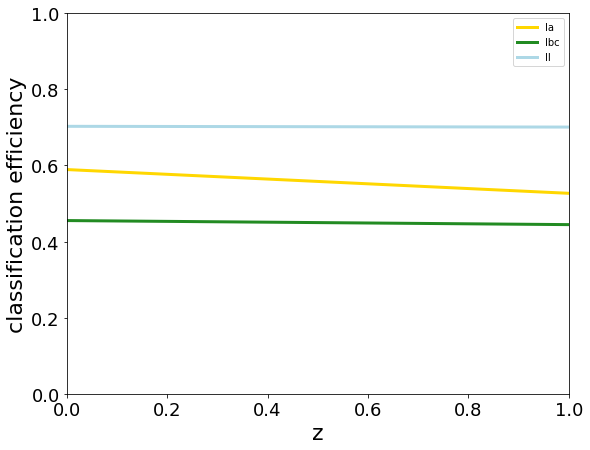

In [469]:
from sklearn import linear_model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

fig, ax= plt.subplots(1,figsize=(9,7))
marker=['s','H','o']
color=['gold', 'forestgreen', 'lightblue']
for i,(data,t) in enumerate(zip([fIa,fIbc,fII],['Ia','Ibc','II'])):
    regr.fit(bins[0:-1,np.newaxis], data)
    yy_pred = regr.predict(np.linspace(0,1,50).reshape(-1, 1))
    ax.plot(np.linspace(0,1,50),yy_pred,'-',lw=3,color=color[i],label=t)
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.tick_params('both', labelsize=18)
    ax.set_ylabel('classification efficiency', fontsize=22)
    ax.set_xlabel('z', fontsize=22)
    plt.legend()